# Environment setting

In [2]:
# Environment setting for Google Colab
!pip install transformers sentence-transformers tqdm

import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from tqdm import tqdm


In [6]:
!pip install flash_attn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [3]:
torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

device(type='cuda')

In [4]:
# Setting seed:

def set_seed_fun(seed_number: int):
    np.random.seed(seed_number)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed_number)
    if torch.cuda.is_available():
        torch.manual_seed(seed_number)
        torch.cuda.manual_seed(seed_number)
        torch.cuda.manual_seed_all(seed_number)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchark = False

set_seed_fun(42)
"""
We could also use pytorch_lightning package
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

pl.seed_everything(42)
"""

'\nWe could also use pytorch_lightning package\ntry:\n    import pytorch_lightning as pl\nexcept ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary\n    !pip install --quiet pytorch-lightning>=1.5\n    import pytorch_lightning as pl\n\npl.seed_everything(42)\n'

In [6]:
# Set up the device (cuda, mps, or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# Load the embedding model (dunzhang/stella_en_1.5B_v5)
model_name = "dunzhang/stella_en_1.5B_v5"
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)


tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_1.5B_v5:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

In [10]:
# Load Dataset
df = pd.read_csv("final_combined_dataset.csv")

In [11]:
# Prepare data
X = df['Text'].values.astype(str)
y = (df['Label'] == 'fake').astype(int).values


In [12]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Embedding

In [15]:
# Modified function without dimension reduction
def generate_stella_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i:i + batch_size]

        with torch.no_grad():
            inputs = tokenizer(batch_texts, padding="longest", truncation=True, max_length=512, return_tensors="pt").to(device)
            attention_mask = inputs["attention_mask"]
            outputs = model(**inputs)[0]
            last_hidden = outputs.masked_fill(~attention_mask[..., None].bool(), 0.0)
            embeddings_batch = last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
            embeddings_batch = normalize(embeddings_batch.cpu().numpy())

            embeddings.append(embeddings_batch)

    return np.vstack(embeddings)




In [16]:
#####################################
# benchmark beginning for embedding #
#####################################
time_start_embed = time.perf_counter()

In [ ]:
# Initialize the Vertex AI TextEmbeddingModel
# embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")

In [18]:
# Ensure data is in the correct format
X_train = X_train.tolist() if isinstance(X_train, np.ndarray) else X_train
X_val = X_val.tolist() if isinstance(X_val, np.ndarray) else X_val
X_test = X_test.tolist() if isinstance(X_test, np.ndarray) else X_test


In [19]:
# Generate embeddings for the train, validation, and test sets
X_train_embeddings = generate_stella_embeddings(X_train, tokenizer, model)
X_val_embeddings = generate_stella_embeddings(X_val, tokenizer, model)
X_test_embeddings = generate_stella_embeddings(X_test, tokenizer, model)


Generating Embeddings: 100%|██████████| 86/86 [02:48<00:00,  1.95s/it]


In [20]:
#####################################
# benchmark ending for embedding    #
#####################################
time_end_embed = time.perf_counter()

# Training part

## Class functions

Definition of functions to:
- Transform a data set into the good format
- create a simple neural network architecture
- create a funtion to transform seconds into a list of (hours, minutes, seconds)

In [21]:
# Define a Dataset class for PyTorch
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)



In [22]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(p=0.6)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(p=0.6)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [23]:
def sec2hms(ss):
	(hh, ss)=divmod(ss, 3600)
	(mm, ss)=divmod(ss, 60)
	return (hh, mm, ss)

## Training function

Definition of the training function.

In [43]:
# Function to train the model
def train_model(X_train, y_train, X_val, y_val, input_size):
    train_dataset = NewsDataset(X_train, y_train)
    val_dataset = NewsDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = SimpleNN(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

    num_epochs = 40
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

       # if patience_counter >= patience:
       #    print("Early stopping")
       #    break

    return model

## Model initialization

## Training

In [25]:
#####################################
# benchmark beginning for modeling  #
#####################################
time_start_model = time.perf_counter()

In [29]:
input_size = 1536

In [27]:
# Set up the device (cuda, mps, or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [44]:
# Train the model
model = train_model(X_train_embeddings, y_train, X_val_embeddings, y_val, input_size)


Epoch 1/40, Validation Loss: 0.6279964169790578
Epoch 2/40, Validation Loss: 0.3129178434610367
Epoch 3/40, Validation Loss: 0.2443572126848753
Epoch 4/40, Validation Loss: 0.22533558551655258
Epoch 5/40, Validation Loss: 0.21814582791439321
Epoch 6/40, Validation Loss: 0.21328758465689282
Epoch 7/40, Validation Loss: 0.20748482124750003
Epoch 8/40, Validation Loss: 0.20409473707509596
Epoch 9/40, Validation Loss: 0.204960219735323
Epoch 10/40, Validation Loss: 0.20094959022000777
Epoch 11/40, Validation Loss: 0.19805028809364453
Epoch 12/40, Validation Loss: 0.19671341863482497
Epoch 13/40, Validation Loss: 0.19349178845106169
Epoch 14/40, Validation Loss: 0.19266177072774532
Epoch 15/40, Validation Loss: 0.1925842652833739
Epoch 16/40, Validation Loss: 0.1914961660324141
Epoch 17/40, Validation Loss: 0.19157384249360063
Epoch 18/40, Validation Loss: 0.19299672058848447
Epoch 19/40, Validation Loss: 0.1954371587828148
Epoch 20/40, Validation Loss: 0.19008111433927402
Epoch 21/40, Vali

In [31]:
#####################################
# benchmark ending for modeling     #
#####################################
time_end_model = time.perf_counter()

## Evaluating

In [45]:
# Evaluate the model on the test set
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch in torch.tensor(X_test_embeddings, dtype=torch.float32).to(device):
        outputs = model(X_batch.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.cpu().numpy()[0])


In [46]:
# Evaluate performance
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["real", "fake"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc}")
print(f"Classification Report:{class_report}")
print(f"Confusion Matrix:{conf_matrix}")


Accuracy: 0.934402332361516
Classification Report:              precision    recall  f1-score   support

        real       0.93      0.94      0.94      1413
        fake       0.94      0.93      0.93      1331

    accuracy                           0.93      2744
   macro avg       0.93      0.93      0.93      2744
weighted avg       0.93      0.93      0.93      2744

Confusion Matrix:[[1332   81]
 [  99 1232]]


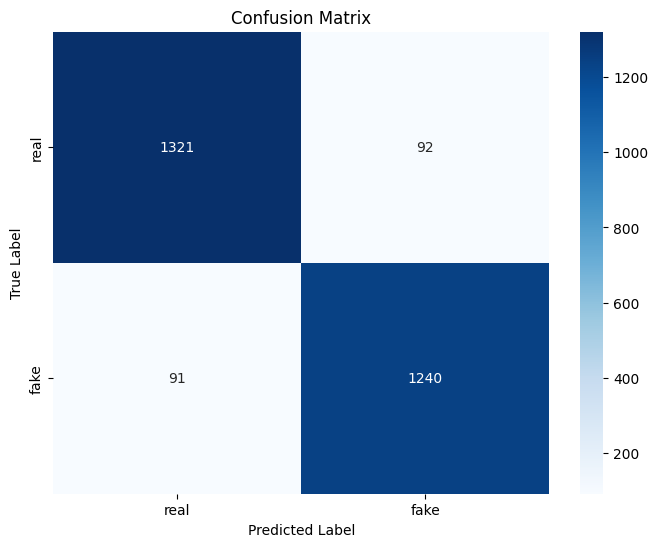

In [34]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Benchmark results

In [35]:
#####################################
#          Benchmark results        #
#####################################
# calculating the performances
embedding_duration = time_end_embed - time_start_embed
modeling_duration = time_end_model - time_start_model

# formating
embedding_duration_hms = sec2hms(embedding_duration)
modeling_duration_hms = sec2hms(modeling_duration)

# printing the embedding and modeling performances

print(f'Embedding duration : {embedding_duration_hms[0]:.0f}:{embedding_duration_hms[1]:.0f}:{embedding_duration_hms[2]:.3f}')
print(f'Modeling duration : {modeling_duration_hms[0]:.0f}:{modeling_duration_hms[1]:.0f}:{modeling_duration_hms[2]:.3f}')

Embedding duration : 0:19:22.486
Modeling duration : 0:1:30.960


In [ ]:
## we should write a function with an if else condition for when a drive is in and where there's not
# Save the trained model to Google Drive
# final_model_path = '/content/drive/My Drive/fake_news_model_roberta3.pth'
# torch.save(model.state_dict(), final_model_path)
# print(f"Model saved to: {final_model_path}")
torch.save(model.state_dict(), "model.tar")
